# ![Spark Logo](http://spark-mooc.github.io/web-assets/images/ta_Spark-logo-small.png) + ![Python Logo](http://spark-mooc.github.io/web-assets/images/python-logo-master-v3-TM-flattened_small.png)
# **Linear Regression Lab**
#### This lab covers a common supervised learning pipeline, using a subset of the Deerfoot Trail data introduced in a previous lab. Our goal is to train a linear regression model to predict Deerfoot commute times given weather and accident conditions
#### ** This lab will cover: **
   #### *Part 1:* Read and parse the initial dataset
   #### *Part 2:* Create and evaluate a baseline model
   #### *Part 3:* Train and evaluate a linear regression model
   #### *Part 5:* Add higher order behaviour and interactions between features
 
#### Note that, for reference, you can look up the details of the relevant Spark methods in [Spark's Python API](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD) and the relevant NumPy methods in the [NumPy Reference](http://docs.scipy.org/doc/numpy/reference/index.html)

In [1]:
from pyspark import SparkContext
sc = SparkContext()

### ** Part 1: Read and parse the initial dataset **

#### ** (1a) Load and check the data **
#### The raw data is currently stored in 3 text files.  Commute time data is stored in one of these files. This is the same file you used in a previous lab.  Weather data for the duration of the commute time dataset is stored in 2 separate files - one for 2013 and one for 2014.  This data was obtained from Environment Canada.  We will start by storing the commute time data in a RDD and the weather data in 2 separate RDDs.  Each element of these RDDs is a comma separated string.  Use the [count method](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.count) to check how many data points/lines we have in each of the RDDs.  Then use the [take method](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.take) to create and print out a list of the first 2 data points in their initial string format from the commute time RDD and first 15 lines from each of the weather RDDs.

In [2]:
fileName1 = 'deerfoot_part2-1.csv'
fileName2 = 'eng-daily-01012013-12312013.csv'
fileName3 ='eng-daily-01012014-12312014.csv'
#sc.pythonExec="/home/vagrant/ondita/envs/py27/bin/python"
deerfootRDD = sc.textFile(fileName1, 8)
weather2013RDD = sc.textFile(fileName2,8)
weather2014RDD = sc.textFile(fileName3,8)


In [3]:
# TODO: Replace <FILL IN> with appropriate code
numPoints = deerfootRDD.count()
print numPoints
samplePoints = deerfootRDD.map(lambda x: x.split(",")[2:4]).count()
print samplePoints

num2013WeatherLines = weather2013RDD.count()
num2014WeatherLines = weather2014RDD.count()
print num2013WeatherLines
print num2014WeatherLines
sample2013WeatherLines = weather2013RDD.take(15)
sample2014WeatherLines = weather2014RDD.take(15)
print sample2013WeatherLines
print sample2014WeatherLines

202
202
391
391
[u'"Station Name","CALGARY INTL A"', u'"Province","ALBERTA"', u'"Latitude","51.12"', u'"Longitude","-114.01"', u'"Elevation","1099.10"', u'"Climate Identifier","3031092"', u'"WMO Identifier","71877"', u'"TC Identifier","YYC"', u'', u'"Legend"', u'"A","Accumulated"', u'"C","Precipitation occurred, amount uncertain"', u'"E","Estimated"', u'"F","Accumulated and estimated"', u'"L","Precipitation may or may not have occurred"']
[u'"Station Name","CALGARY INTL A"', u'"Province","ALBERTA"', u'"Latitude","51.12"', u'"Longitude","-114.01"', u'"Elevation","1099.10"', u'"Climate Identifier","3031092"', u'"WMO Identifier","71877"', u'"TC Identifier","YYC"', u'', u'"Legend"', u'"A","Accumulated"', u'"C","Precipitation occurred, amount uncertain"', u'"E","Estimated"', u'"F","Accumulated and estimated"', u'"L","Precipitation may or may not have occurred"']


#### ** (1b) Preprocessing RDDs - extracting desired fields from commute time data **
#### We need to pre-process the RDDs before we can use them for training a regression model.  For this exercise, we will consider predicting the commute time at 5 PM in the evening when traffic is typically heavy.  As a result we won't be using all the fields in the 'deerfootRDD'.  Specifically, we will only be using the following fields - Date (field0), Day(field1), Commute Time at 5 PM (field15), and Total number of accidents (field46).  Use a Spark transformation to create a new pairRDD whose key is the Date and whose value is the tuple (Day, Commute Time at 5 PM, Total number of accidents). You need to use the function 'extractFields' to achieve this.  Print the first 2 elements of the resulting pairRDD as a check to see if you extracted the correct fields., `u'split,me'.split(',')` returns `[u'split', u'me']`.

In [4]:
# TODO: Replace <FILL IN> with appropriate code
def extractFields(deerfootRDDRecord):
    """Creates a key-value pair consisting of the Date field as the key and the the tuple (Day,Commute Time at 5 PM, Total number of Accidents) as the value

    Args:
        deerfootRDDRecord : a comma separated string consisting of all fields in the data set.

    Returns:
        extracted record: key-value pair as detailed above
    """
    fieldsList = deerfootRDDRecord.split(",")
    return (fieldsList[0], [fieldsList[1], fieldsList[15], fieldsList[46]])
deerfootPairRDD = deerfootRDD.map(extractFields)
print deerfootPairRDD.take(1)

[(u'21/09/2013', [u'Saturday', u'35', u'2'])]


#### ** (1c) Preprocessing RDDs - extracting desired lines from weather data **
#### If you notice the output of the weather files the first few lines don't contain the data - they contain metadata and column labels.  These need to be removed.  Use a Spark transformation to discard unwanted metadata and header information.  Hint: You can see whether a unicode string string1 contains another string in variable string2 using 'u'string1' in string2'

In [5]:
# TODO: Replace <FILL IN> with appropriate code
def filterLines(weatherRDDRecord):
    """ Skips lines with metadata and label information
    Args:
        weatherRDDRecord : a line from the weather file.

    Returns:
        True - if line is not metadata/label; False otherwise
    """
    fieldsList = weatherRDDRecord.split(",")
    #return len(fieldsList)
    if any(i.isdigit() for i in fieldsList[0]):
        return True
    else:
        return False

filteredWeather2013RDD = weather2013RDD.filter(lambda x: filterLines(x))
filteredWeather2014RDD = weather2014RDD.filter(lambda x: filterLines(x))
print filteredWeather2013RDD.take(5)
print filteredWeather2014RDD.take(5)

[u'"2013-01-01","2013","01","01","\ufffd","1.2","","-8.9","","-3.9","","21.9","","0.0","","0.0","T","0.0","","0.0","T","4","","33","","48",""', u'"2013-01-02","2013","01","02","\ufffd","5.8","","-10.9","","-2.6","","20.6","","0.0","","0.0","","0.0","","0.0","","3","","29","","41",""', u'"2013-01-03","2013","01","03","\ufffd","8.8","","-8.8","","0.0","","18.0","","0.0","","0.0","","0.0","","0.0","","2","","28","","52",""', u'"2013-01-04","2013","01","04","\ufffd","2.9","","-11.2","","-4.2","","22.2","","0.0","","0.0","","0.0","","0.0","","2","","26","","63",""', u'"2013-01-05","2013","01","05","\ufffd","4.8","","-10.0","","-2.6","","20.6","","0.0","","0.0","","0.0","","0.0","","1","","27","","41",""']
[u'"2014-01-01","2014","01","01","\ufffd","-0.6","","-9.7","","-5.2","","23.2","","0.0","","0.0","","1.0","","0.8","","9","","","","<31",""', u'"2014-01-02","2014","01","02","\ufffd","8.5","","-10.0","","-0.8","","18.8","","0.0","","0.0","","0.0","","0.0","","11","","27","","52",""', u'"20

#### ** (1d) Preprocessing RDDs - Fixing date format inconsistency**
#### If you compare the Date fields of the commute time and weather files you will notice that they are in different formats.  While the date in the commute time file is in the format "day/month/year" it is in the format "year-month-day".  We need to fix things so that the weather data has the same date format as the commute time data. (It is very typical to deal with such annoyances while developing models from different data sources). Use a Spark transformation that constructs a pairRDD whose key is the date and whose value is a tuple containing the rest of the columns of the weather data.  Note, you need to construct 2 pairRDDs, one for 2013 and another for 2014.  Also, as mentioned previously, you need to fix the date formatting such that it matches the formatting in the commute time data.

In [6]:
# TODO: Replace <FILL IN> with appropriate code
def fixDate(weatherRDDRecord):
    """Creates a key-value pair - key is date in format 'day/month/year' value - a comma separated string containing other fields of the record
    Args:
        weatherRDDRecord : a comma separated string consisting of all fields in the weather data set.

    Returns:
        extracted record: key-value pair as detailed above
    """
    fieldList = weatherRDDRecord.split(",")
    fieldList = [i.replace('\"', '') for i in fieldList]    #remove quotation marks
    fieldList[0] = fieldList[0].replace('-', '/')
    
    swapDateOrder = fieldList[0].split('/')
    fieldList[0] = swapDateOrder[2] + '/' + swapDateOrder[1] + '/' + swapDateOrder[0]
    
    return (fieldList[0],(fieldList[1:]))
   
fixedWeather2013RDD = filteredWeather2013RDD.map(fixDate)
fixedWeather2014RDD = filteredWeather2014RDD.map(fixDate)
#print type(fixedWeather2014RDD.collect())
print fixedWeather2013RDD.take(2)
print fixedWeather2014RDD.take(2)

[(u'01/01/2013', [u'2013', u'01', u'01', u'\ufffd', u'1.2', u'', u'-8.9', u'', u'-3.9', u'', u'21.9', u'', u'0.0', u'', u'0.0', u'T', u'0.0', u'', u'0.0', u'T', u'4', u'', u'33', u'', u'48', u'']), (u'02/01/2013', [u'2013', u'01', u'02', u'\ufffd', u'5.8', u'', u'-10.9', u'', u'-2.6', u'', u'20.6', u'', u'0.0', u'', u'0.0', u'', u'0.0', u'', u'0.0', u'', u'3', u'', u'29', u'', u'41', u''])]
[(u'01/01/2014', [u'2014', u'01', u'01', u'\ufffd', u'-0.6', u'', u'-9.7', u'', u'-5.2', u'', u'23.2', u'', u'0.0', u'', u'0.0', u'', u'1.0', u'', u'0.8', u'', u'9', u'', u'', u'', u'<31', u'']), (u'02/01/2014', [u'2014', u'01', u'02', u'\ufffd', u'8.5', u'', u'-10.0', u'', u'-0.8', u'', u'18.8', u'', u'0.0', u'', u'0.0', u'', u'0.0', u'', u'0.0', u'', u'11', u'', u'27', u'', u'52', u''])]


#### ** (1e) Extracting the desired days from weather data**
#### commute times have been recorded for the period September 21, 2013 to April 10, 2014.  We need to consider only the weather data for this period while building the linear regression model.  Use a Spark transformation to append the 'fixedWeather2014' RDD to the 'fixedWeather2013' RDD to create a new RDD.  Then, use another Spark transformation to filter out days before September 21, 2013 and days after April 10, 2014.

In [7]:
# TODO: Replace <FILL IN> with appropriate code
def filterDates(weatherRDDRecord):
    """Skips records before September 21, 2013 and after April 10, 2014
    Args:
        weatherRDDRecord : key-value record where key is date and value is comma separated string of other weather fields

    Returns:
        True if key is in the desired period; False otherwise
    """
    import datetime
    startDate = str(datetime.date(2013, 9, 21))
    endDate = str(datetime.date(2014, 4, 10))

    recordDate = weatherRDDRecord[0].split("/")
    currentDate = str(datetime.date(int(recordDate[2]), int(recordDate[1]), int(recordDate[0])))
    
    if startDate <= currentDate <= endDate:
        return True
    else:
        return False

aggregateWeatherRDD = fixedWeather2013RDD.union(fixedWeather2014RDD)
print aggregateWeatherRDD.count()
desiredWeatherRDD = aggregateWeatherRDD.filter(lambda x: filterDates(x))
#desiredWeatherRDD = aggregateWeatherRDD.map(filterDates)
print desiredWeatherRDD.take(5)
print desiredWeatherRDD.count()

730
[(u'21/09/2013', [u'2013', u'09', u'21', u'\ufffd', u'24.0', u'', u'5.5', u'', u'14.8', u'', u'3.2', u'', u'0.0', u'', u'0.0', u'', u'0.0', u'', u'0.0', u'', u'', u'', u'21', u'', u'63', u'']), (u'22/09/2013', [u'2013', u'09', u'22', u'\ufffd', u'20.1', u'', u'3.8', u'', u'12.0', u'', u'6.0', u'', u'0.0', u'', u'0.0', u'T', u'0.0', u'', u'0.0', u'T', u'', u'', u'26', u'', u'39', u'']), (u'23/09/2013', [u'2013', u'09', u'23', u'\ufffd', u'17.6', u'', u'5.3', u'', u'11.5', u'', u'6.5', u'', u'0.0', u'', u'0.0', u'', u'0.0', u'', u'0.0', u'', u'', u'', u'27', u'', u'59', u'']), (u'24/09/2013', [u'2013', u'09', u'24', u'\ufffd', u'14.4', u'', u'3.9', u'', u'9.2', u'', u'8.8', u'', u'0.0', u'', u'0.0', u'', u'0.0', u'', u'0.0', u'', u'', u'', u'27', u'', u'37', u'']), (u'25/09/2013', [u'2013', u'09', u'25', u'\ufffd', u'11.3', u'', u'1.6', u'', u'6.5', u'', u'11.5', u'', u'0.0', u'', u'0.0', u'', u'0.0', u'', u'0.0', u'', u'', u'', u'34', u'', u'50', u''])]
202


#### ** (1e) Merging commute time and weather data**
#### We have to merge the commute time RDD 'deerfootPairRDD' and the weather RDD 'desiredWeatherRDD'.  Use an appropriate Spark transformation that uses the common key date key in both RDDs.  Print the number of elements and the first 5 elements of the resulting RDD.

In [8]:
# TODO: Replace <FILL IN> with appropriate code
#print deerfootPairRDD.take(2)
#print desiredWeatherRDD.take(2)
combinedPairRDD = deerfootPairRDD.join(desiredWeatherRDD)
print combinedPairRDD.take(5)
#print combinedPairRDD

[(u'08/03/2014', ([u'Saturday', u'35', u'2'], [u'2014', u'03', u'08', u'\ufffd', u'12.4', u'', u'-4.5', u'', u'4.0', u'', u'14.0', u'', u'0.0', u'', u'0.0', u'', u'0.0', u'', u'0.0', u'', u'1', u'', u'23', u'', u'59', u''])), (u'31/03/2014', ([u'Monday', u'38', u'7'], [u'2014', u'03', u'31', u'\ufffd', u'-9.4', u'', u'-14.7', u'', u'-12.1', u'', u'30.1', u'', u'0.0', u'', u'', u'M', u'1.2', u'', u'0.8', u'', u'10', u'', u'', u'', u'<31', u''])), (u'07/10/2013', ([u'Monday', u'46', u'5'], [u'2013', u'10', u'07', u'\ufffd', u'17.9', u'', u'5.6', u'', u'11.8', u'', u'6.2', u'', u'0.0', u'', u'0.0', u'', u'0.0', u'', u'0.0', u'', u'', u'', u'28', u'', u'61', u''])), (u'06/01/2014', ([u'Monday', u'45', u'4'], [u'2014', u'01', u'06', u'\ufffd', u'3.4', u'', u'-14.8', u'', u'-5.7', u'', u'23.7', u'', u'0.0', u'', u'0.0', u'', u'0.0', u'', u'0.0', u'', u'10', u'', u'29', u'', u'33', u''])), (u'26/11/2013', ([u'Tuesday', u'44', u'6'], [u'2013', u'11', u'26', u'\ufffd', u'10.2', u'', u'-5.6', u'

#### ** (1f) Filter out weekends and unwanted weather fields to produce fina data for regression**
#### Predicting commute times is more crucial for weekdays than for weekends, which have very light traffic.  So, we will exclude saturdays and sundays from the combined dataset.  We will also only consider using the number of accidents and the "Snow on the ground" fields of the combined dataset while building our predictive model.  While other fields, e.g., temperature, might also impact commute times, we will ignore them for the sake of simplicity.  As a result, we need to filter out the unwanted fields.  Use appropriate Spark transformations to produce an RDD whose each record has the format "commute time, number of accidents, snow on the ground". If the "snow on the ground" field is "", i.e., data was not logged that day, then assume that it is "0", i.e., assume that day had 0 snow on the ground.

In [9]:
# TODO: Replace <FILL IN> with appropriate code
def filterWeekends(combinedPairRDDRecord):
    """Skips records corresponding to Saturdays and Sundays
    Args:
        combinedPairRDDRecord : key-value record where key is date and value is a tuple containing comma-separated string values from deerfootPairRDD and desiredWeatherRDD 

    Returns:
        True if key is in the desired period; False otherwise
    """
    recordRDD = combinedPairRDDRecord[1]
    dayOfWeek = recordRDD[0][0]
    
    if dayOfWeek != 'Saturday' and dayOfWeek != 'Sunday':
        return True
    else:
        return False
    
def extractRegressionData(combinedPairRDDWeekdaysRecord):
    """Outputs a string record with the format "commute time,number of accidents, snow on ground"
    Args:
        combinedPairRDDWeekdaysRecord: key-value record where key is date and value is a tuple containing comma-separated string values from deerfootPairRDD and desiredWeatherRDD 
    
    Returns:
        record with the format "commute time,number of accidents, snow on ground
    """
    commuteFields = combinedPairRDDWeekdaysRecord[1][0]
    weatherFields = combinedPairRDDWeekdaysRecord[1][1]
    
    # Assuming 'Snow on ground' field is index 20, if I counted right
    if str(weatherFields[20]) == '':
        weatherFields[20] = '0'
    
    desiredFieldList = commuteFields[1] + ',' + commuteFields[2] + ',' + weatherFields[20]
    return desiredFieldList

combinedPairRDDWeekdays = combinedPairRDD.filter(lambda x: filterWeekends(x))
#combinedPairRDDWeekdays = combinedPairRDD.map(filterWeekends)
#print combinedPairRDDWeekdays.take(10) #own print function
regressionDataRDD = combinedPairRDDWeekdays.map(extractRegressionData)
print regressionDataRDD.count()
print regressionDataRDD.take(5)

144
[u'38,7,10', u'46,5,0', u'45,4,10', u'44,6,0', u'40,5,0']


#### ** (1g) Using `LabeledPoint` **
#### We are now ready to use MLlib to do regression!  In MLlib, labeled training instances are stored using the [LabeledPoint](https://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.regression.LabeledPoint) object.  Write the parsePoint function that takes as input a raw data point in 'regressionDataRDD', parses it using Python's [unicode.split](https://docs.python.org/2/library/string.html#string.split) method, and returns a `LabeledPoint`.  Use this function to parse samplePoints (from the previous question).  Then print out the features and label for the first training point, using the `LabeledPoint.features` and `LabeledPoint.label` attributes. Finally, calculate the number features for this dataset.

In [10]:
from pyspark.mllib.regression import LabeledPoint
import numpy as np,numpy
# Here is a sample raw data point:
# u'49,14,16'
# In this raw data point, 49 is the label, and the remaining values are features

In [11]:
# TODO: Replace <FILL IN> with appropriate code
def parsePoint(line):
    """Converts a comma separated unicode string into a `LabeledPoint`.

    Args:
        line (unicode): Comma separated unicode string where the first element is the label and the
            remaining elements are features.

    Returns:
        LabeledPoint: The line is converted into a `LabeledPoint`, which consists of a label and
            features.
    """
    parts = line.split(",")
    return LabeledPoint(parts[0], [parts[1], parts[2]])


parsedSamplePoints = regressionDataRDD.map(lambda x: parsePoint(x))
firstPoint = parsedSamplePoints.take(1)[0]
print firstPoint
firstPointFeatures = firstPoint.features
firstPointLabel = firstPoint.label
print firstPointFeatures, firstPointLabel
# d contains the number of features
d = len(firstPointFeatures)
print d

(38.0,[7.0,10.0])
[7.0,10.0] 38.0
2


# **(1h) Feature scaling **
#### In learning problems, it is often necessary to "scale" features so that all features span nearly the same range.  One way to do this is to do (featureValue-meanOfFeatureValues)/standardDeviationOfFeatureValues.  For a given feature, the mean and standard deviation of its feature values are calculated.  Then, the mean is subtracted from each value and the result is then divided by the standard deviation. 

#### We will now do feature scaling for our dataset.  First implement a 'getNormalizedRDD' function that takes the RDD with non-scaled values and returns an RDD containing scaled features.  This function will first calculate the mean and standard deviations of the features in the non-scaled RDD.  It will then use a Spark transformation to scale each element of the non-scaled RDD.  This transformation should use the 'normalizeFeatures' closure listed below. Note that your implementation should generalize to any arbitrary number of features.

In [59]:
# TODO: Replace <FILL IN> with appropriate code
import math

meanOfFeatures = []
stdDevFeatures = []

def normalizeFeatures(lp):
    """Normalizes features in the LabeledPoint object lp.

    Args:
        lp - LabeledPoint object 

    Returns:
        LabeledPoint: The object contains the label and the normalized features
    """
    # optimized for any sized feature vector
    numFeatures = len(lp.features)
    featureList = []
    for i in range(numFeatures):
        normalizedFeature = (lp.features[i] - meanOfFeatures[i])/stdDevFeatures[i]
        featureList.append(normalizedFeature)
    returnLabeledPoint = LabeledPoint(lp.label, featureList)
    return returnLabeledPoint
    
def getNormalizedRDD(nonNormalizedRDD): 
    """Normalizes the features of the LabeldPoints contained in nonNormalizedRDD.

    Args:
        nonNormalizedRDD - RDD containing non-normalized features 

    Returns:
        returnRDD: RDD containing normalized features
    """
    totalOfFeatures = []
    numFeatures = len(nonNormalizedRDD.take(1)[0].features)
    for i in range(numFeatures):
        meanOfFeatures.append(nonNormalizedRDD.map(lambda x: x.features[i]).mean())
        stdDevFeatures.append(np.std(nonNormalizedRDD.map(lambda x: x.features[i]).collect()))
    returnRDD = nonNormalizedRDD.map(lambda x: normalizeFeatures(x))
    return returnRDD

normalizedSamplePoints = getNormalizedRDD(parsedSamplePoints)
print meanOfFeatures
print stdDevFeatures
print normalizedSamplePoints.take(5)

[5.1736111111111116, 3.8680555555555558]
[2.9470556424805663, 5.4699260199366728]
[LabeledPoint(38.0, [0.619733425648,1.12102877116]), LabeledPoint(46.0, [-0.0589100214494,-0.707149519291]), LabeledPoint(45.0, [-0.398231744998,1.12102877116]), LabeledPoint(44.0, [0.280411702099,-0.707149519291]), LabeledPoint(40.0, [-0.0589100214494,-0.707149519291])]


#### ** (1i) Training and validation sets **
#### We're almost done parsing our dataset, and our final task involves split it into a training set and a validation set. Use the [randomSplit method](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.randomSplit) with the specified weights and seed to create RDDs storing each of these datasets. Next, cache each of these RDDs, as we will be accessing them multiple times in the remainder of this lab. Finally, compute the size of each dataset and verify that the sum of their sizes equals the value computed in Part (1f).

In [60]:
# TODO: Replace <FILL IN> with appropriate code
weights = [.8, .2]
seed = 42
parsedTrainData, parsedValData = normalizedSamplePoints.randomSplit(weights, seed)
parsedTrainData.cache()
parsedValData.cache()
nTrain = parsedTrainData.count()
nVal = parsedValData.count()

print nTrain, nVal, nTrain + nVal
print normalizedSamplePoints.count()

113 31 144
144


### ** Part 2: Create and evaluate a baseline model **

#### **(2a) Average label **
#### A very simple yet natural baseline model is one where we always make the same prediction independent of the given data point, using the average label in the training set as the constant prediction value.  Compute this value, which is the average commute time for the training set.  Use an appropriate method in the [RDD API](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD).

In [61]:
# TODO: Replace <FILL IN> with appropriate code
averageCommuteTime = parsedTrainData.map(lambda x: x.label).mean()
                   
print averageCommuteTime

44.6991150442


#### **(2b) Root mean squared error **
#### We naturally would like to see how well this naive baseline performs.  We will use root mean squared error ([RMSE](http://en.wikipedia.org/wiki/Root-mean-square_deviation)) for evaluation purposes.  Implement a function to compute RMSE given an RDD of (label, prediction) tuples, and test out this function on an example.

In [62]:
# TODO: Replace <FILL IN> with appropriate code
import math
def squaredError(label, prediction):
    """Calculates the the squared error for a single prediction.

    Args:
        label (float): The correct value for this observation.
        prediction (float): The predicted value for this observation.

    Returns:
        float: The difference between the `label` and `prediction` squared.
    """
    return (label-prediction)*(label-prediction)

def calcRMSE(labelsAndPreds):
    """Calculates the root mean squared error for an `RDD` of (label, prediction) tuples.

    Args:
        labelsAndPred (RDD of (float, float)): An `RDD` consisting of (label, prediction) tuples.

    Returns:
        float: The square root of the mean of the squared errors.
    """
    meanOfSqErrors = labelsAndPreds.map(lambda (x,y): squaredError(x,y)).mean()
    
    return math.sqrt(meanOfSqErrors)
    
labelsAndPreds = sc.parallelize([(3., 1.), (1., 2.), (2., 2.)])
exampleRMSE = calcRMSE(labelsAndPreds)
print exampleRMSE

1.29099444874


#### **(2c) Training validation RMSE **
#### Now let's calculate the training and validation RMSE of our baseline model. To do this, first create RDDs of (label, prediction) tuples for each dataset, and then call calcRMSE. Note that each RMSE can be interpreted as the average prediction error for the given dataset (in terms of commute time).

In [63]:
# TODO: Replace <FILL IN> with appropriate code
#print parsedTrainData.collect()
labelsAndPredsTrain = parsedTrainData.map(lambda x: (x.label, averageCommuteTime))
rmseTrainBase = calcRMSE(labelsAndPredsTrain)
labelsAndPredsVal = parsedValData.map(lambda x: (x.label, averageCommuteTime))
rmseValBase = calcRMSE(labelsAndPredsVal)
print 'Baseline Train RMSE = {0:.3f}'.format(rmseTrainBase)
print 'Baseline Validation RMSE = {0:.3f}'.format(rmseValBase)

Baseline Train RMSE = 9.602
Baseline Validation RMSE = 5.098


### ** Part 3: Train linear regression models using MLlib  **

#### **(3a) `LinearRegressionWithSGD` **
#### MLlib's [LinearRegressionWithSGD](https://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.regression.LinearRegressionWithSGD) implements linear regression with advanced functionality, such as stochastic gradient approximation and allowing both L1 or L2 regularization.  First use LinearRegressionWithSGD to train a model with L2 regularization and with an intercept.  This method returns a [LinearRegressionModel](https://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.regression.LinearRegressionModel).  Next, use the model's [weights](http://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.regression.LinearRegressionModel.weights) and [intercept](http://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.regression.LinearRegressionModel.intercept) attributes to print out the model's parameters.

In [64]:
from pyspark.mllib.linalg import DenseVector
from pyspark.mllib.regression import LinearRegressionWithSGD
# Values to use when training the linear regression model
numIters = 500  # iterations
alpha = 1.0  # step
miniBatchFrac = 1.0  # miniBatchFraction
reg = 1e-1  # regParam
regType = 'l2'  # regType
useIntercept = True  # intercept

In [65]:
from pyspark.ml.regression import LinearRegression
# TODO: Replace <FILL IN> with appropriate code
firstModel = LinearRegressionWithSGD.train(parsedTrainData, numIters, 
                                           alpha, miniBatchFrac, None, 
                                           reg, regType, useIntercept)


# weightsLR1 stores the model weights; interceptLR1 stores the model intercept
weightsLR1 =  firstModel.weights
interceptLR1 =  firstModel.intercept
print weightsLR1, interceptLR1

[2.95770983783,1.69699224572] 40.6023578482


#### **(3b) Predict**
#### Now use the [LinearRegressionModel.predict()](http://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.regression.LinearRegressionModel.predict) method to make a prediction on a sample point.  Pass the `features` from a `LabeledPoint` into the `predict()` method.

In [66]:
# TODO: Replace <FILL IN> with appropriate code
#samplePoint = parsedTrainData.map(lambda x: x.features).collect()[0]
#samplePrediction = firstModel.predict(samplePoint)
samplePrediction = parsedTrainData.map(lambda x: firstModel.predict(x.features)).collect()
print samplePrediction

[44.337726629955398, 39.228091847411342, 41.326881030169332, 40.231707047340031, 39.228091847411342, 43.571457983172692, 53.772062650482866, 41.472668800414702, 39.228091847411342, 41.710015353560685, 39.538332285680013, 34.210015847767906, 46.873879123449498, 44.720860953346751, 43.498564098050004, 37.220861447553972, 39.538332285680013, 40.852187923877366, 38.22447664748266, 42.640736668366685, 40.231707047340031, 40.852187923877366, 37.385314115577266, 42.713630553489374, 39.228091847411342, 37.220861447553972, 49.811830838112883, 37.220861447553972, 42.166043562074726, 40.870852821655291, 42.038920689607281, 39.848572723948678, 39.702784953703308, 36.837727124162612, 37.002179792185913, 41.235322247268719, 34.210015847767906, 37.220861447553972, 36.144352362502595, 40.469053600486014, 36.217246247625283, 37.458208000699948, 44.866648723592121, 53.224475659068226, 40.231707047340031, 39.538332285680013, 36.217246247625283, 42.549177885466079, 41.235322247268719, 38.461823200628636, 

#### ** (3c) Evaluate RMSE **
#### Next evaluate the accuracy of this model on the validation set.  Use the `predict()` method to create a `labelsAndPreds` RDD, and then use the `calcRMSE()` function from Part (2b).

In [67]:
# TODO: Replace <FILL IN> with appropriate code
labelsAndPreds = parsedValData.map(lambda x: (x.label, firstModel.predict(x.features)))
print labelsAndPreds.take(10)
rmseValLR1 = calcRMSE(labelsAndPreds)

print rmseValBase
print rmseValLR1

[(43.0, 39.775678838825996), (42.0, 37.220861447553972), (45.0, 46.272063144690087), (48.0, 39.228091847411342), (43.0, 48.826880535962118), (38.0, 37.220861447553972), (45.0, 42.238937447197408), (42.0, 40.231707047340031), (46.0, 40.231707047340031), (57.0, 49.757601850768118)]
5.0975954081
5.49109858333


#### ** (3d) Trying a 2nd order model **
#### The linear model is already outperforming the baseline on the validation set by more than a minute on average, but let's see if we can do better. Let's see if a 2nd order model will lead to better predictions. A 2nd order model will have as features [num of accidents, snoOnGround, (num of accidents)^2, (snoOnGround)^2,(num of accidents * snoOnGround)].  First, we will use a Spark transformation to convert the 'parsedSamplePoints' RDD to an RDD that has LabeledPoint objects for the 2nd order modelling. Next, we will scale the features of 2nd order RDD.

In [71]:
# TODO: Replace <FILL IN> with appropriate code
def transformOrderTwo(lp):
    """Transforms the features in the LabeledPoint object lp into higher order features.

    Args:
        lp - LabeledPoint object 

    Returns:
        LabeledPoint: The object contains the label and the higher order features
    """
    new_point = LabeledPoint(lp.label, [lp.features[0],
                                       lp.features[1],
                                       lp.features[0]*lp.features[0],
                                       lp.features[1]*lp.features[1],
                                       lp.features[0]*lp.features[1]])
                                       
    return new_point

orderTwoParsedSamplePoints = parsedSamplePoints.map(transformOrderTwo)
print orderTwoParsedSamplePoints.take(2)
# cleaning global lists
meanOfFeatures = []
stdDevFeatures = []
normalizedOrderTwoSamplePoints = getNormalizedRDD(orderTwoParsedSamplePoints)
print normalizedOrderTwoSamplePoints.take(2)

[LabeledPoint(38.0, [7.0,10.0,49.0,100.0,70.0]), LabeledPoint(46.0, [5.0,0.0,25.0,0.0,0.0])]
[LabeledPoint(38.0, [0.619733425648,1.12102877116,0.343454325969,0.559797993334,1.06019810531]), LabeledPoint(46.0, [-0.0589100214494,-0.707149519291,-0.264940420597,-0.455836516432,-0.533419088477])]


#### ** (3e) Creating training and validation sets for 2nd order model **
#### Follow the procedure in 1(i) to create a training and validation set for the 2nd order model

In [72]:
# TODO: Replace <FILL IN> with appropriate code
weights = [.8, .2]
seed = 42
parsedTrainDataOrderTwo, parsedValDataOrderTwo = normalizedOrderTwoSamplePoints.randomSplit(weights, seed)

nTrain = parsedTrainDataOrderTwo.count()
nVal = parsedValDataOrderTwo.count()

print nTrain, nVal, nTrain + nVal
print normalizedOrderTwoSamplePoints.count()

113 31 144
144


#### ** (3f) Train the 2nd order model using the training set **

In [73]:
# TODO: Replace <FILL IN> with appropriate code
secondModel = LinearRegressionWithSGD.train(parsedTrainDataOrderTwo, numIters, 
                                           alpha, miniBatchFrac, None, 
                                           reg, regType, useIntercept)

# weightsLR2 stores the model weights; interceptLR2 stores the model intercept
weightsLR2 = secondModel.weights
interceptLR2 = secondModel.intercept
print weightsLR2, interceptLR2

[1.30895116266,-0.75464385974,1.12200872569,1.80394308301,1.61548773457] 40.6187779798


#### ** (3g) Evaluate RMSE of 2nd order model **
#### This is similar to what you did in 3(c).

In [74]:
# TODO: Replace <FILL IN> with appropriate code
#secondOrderSamplePrediction = secondModel.predict(parsedTrainDataOrderTwo
                                              #    .map(lambda x: x.features).collect()[0])
secondOrderSamplePrediction = parsedTrainDataOrderTwo.map(lambda x: secondModel.predict(x.features)).collect()
labelsAndPredsOrderTwo = parsedValDataOrderTwo.map(lambda x: (x.label, secondModel.predict(x.features)))
#labelsAndPredsOrderTwo = parsedValDataOrderTwo.map(lambda x: (x.label, secondOrderSamplePrediction))
rmseValLR2 = calcRMSE(labelsAndPredsOrderTwo)

print rmseValBase
print rmseValLR1
print rmseValLR2

5.0975954081
5.49109858333
5.363452407


#### ** Conclusions**
#### You would have noticed a slight improvement in accuracy with the 2nd order model from the 1st order model. To get further improvements we could try a few other things such as using an even higher level model, using more features from the commute time and weather data, and using more data.  We could also use more advaned regression techniques supported by MLlib such as ridge regression.  These are left as future exercises that you can try on your own.

#### To finish things off, here is a plot that compares the actual commute times to those predicted by our best model.  This is basically a a color-coded scatter plot visualizing tuples storing i) the predicted value from this model and ii) true label.  Lighter colour predictions represent lower errors while the red ones represent large errors. 

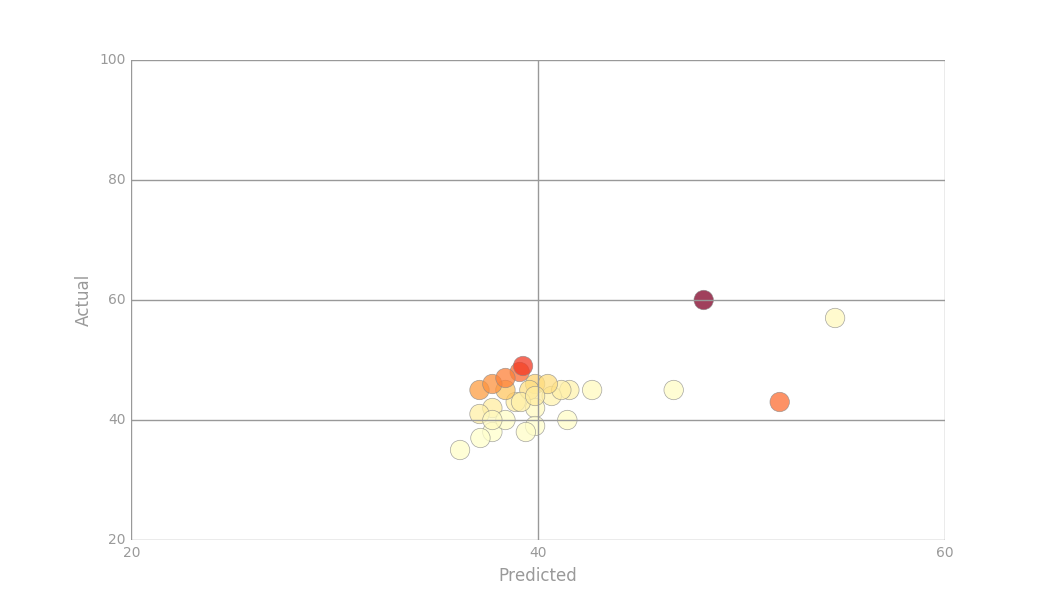

In [75]:
import matplotlib
# force Agg
matplotlib.use('Agg')
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, Normalize
from matplotlib.cm import get_cmap

cmap = get_cmap('YlOrRd')

def preparePlot(xticks, yticks, figsize=(10.5, 6), hideLabels=False, gridColor='#999999',
                gridWidth=1.0):
    """Template for generating the plot layout."""
    plt.close()
    fig, ax = plt.subplots(figsize=figsize, facecolor='white', edgecolor='white')
    ax.axes.tick_params(labelcolor='#999999', labelsize='10')
    for axis, ticks in [(ax.get_xaxis(), xticks), (ax.get_yaxis(), yticks)]:
        axis.set_ticks_position('none')
        axis.set_ticks(ticks)
        axis.label.set_color('#999999')
        if hideLabels: axis.set_ticklabels([])
    plt.grid(color=gridColor, linewidth=gridWidth, linestyle='-')
    map(lambda position: ax.spines[position].set_visible(False), ['bottom', 'top', 'left', 'right'])
    return fig, ax

predictions = np.asarray(parsedValDataOrderTwo
                         .map(lambda lp: secondModel.predict(lp.features))
                         .collect())
actual = np.asarray(parsedValDataOrderTwo
                    .map(lambda lp: lp.label)
                    .collect())
error = np.asarray(parsedValDataOrderTwo
                   .map(lambda lp: (lp.label, secondModel.predict(lp.features)))
                   .map(lambda (l, p): squaredError(l, p))
                   .collect())

norm = Normalize()
clrs = cmap(np.asarray(norm(error)))[:,0:3]

fig, ax = preparePlot(np.arange(0, 120, 20), np.arange(0, 120, 20))
ax.set_xlim(20, 60), ax.set_ylim(20, 100)
plt.scatter(predictions, actual, s=14**2, c=clrs, edgecolors='#888888', alpha=0.75, linewidths=.5)
ax.set_xlabel('Predicted'), ax.set_ylabel(r'Actual')
pass
fig.savefig('temp.png')
Image(filename='temp.png')